<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/S8/Net_GN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 dataset classification
## Net 1

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [1]:
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git

Cloning into 'ERA_V2'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 236 (delta 100), reused 144 (delta 42), pack-reused 0
Receiving objects: 100% (236/236), 27.40 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# del model
import torch
import torch.nn as nn
import torch.optim as optim
from ERA_V2.S8.Utilities.model import Net1
from ERA_V2.S8.Utilities.utils import train, test
import torch.nn.functional as F
from torchsummary import summary

torch.manual_seed(1)

In [4]:
CLASSES = ("Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck")

# Model Initialization & Summary

In [5]:
device = torch.device("cuda")
model = Net1(dropout_percentage=0.02, norm="gn", num_groups=4)
model=model.to("cuda")
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
         GroupNorm-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             528
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,320
        GroupNorm-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
          Dropout-14           [-1, 16,

# Dataset & Dataloaders

In [8]:
from ERA_V2.S8.Utilities.transforms import train_transforms, test_transforms

In [9]:
from ERA_V2.S8.Utilities.dataset import get_dataloaders

batch_size = 64

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}
train_loader, test_loader = get_dataloaders(train_transforms=train_transforms, test_transforms=test_transforms, **kwargs)

100%|██████████| 170498071/170498071 [00:01<00:00, 86144916.72it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Exploration

In [12]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


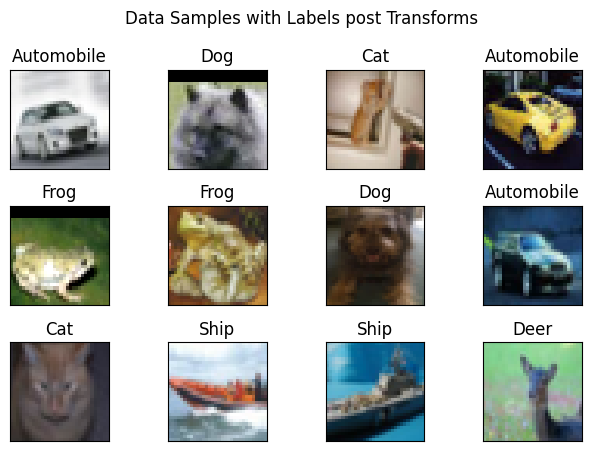

In [13]:
from ERA_V2.S8.Utilities.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=CLASSES)
plot_data_samples(train_loader, classes=CLASSES)

# Training

In [14]:
model = Net1(dropout_percentage=0.0, norm="gn", num_groups=4).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(model, device, train_loader, optimizer, criterion)
  test_accs, test_losses = test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train: 100% Loss=1.5470 Batch_id=781 Accuracy=30.79
Test set: Average loss: 1.5169, Accuracy: 4341/10000 (43.41%)

Epoch 2
Train: 100% Loss=1.1758 Batch_id=781 Accuracy=45.70
Test set: Average loss: 1.2920, Accuracy: 5232/10000 (52.32%)

Epoch 3
Train: 100% Loss=0.8402 Batch_id=781 Accuracy=52.97
Test set: Average loss: 1.1802, Accuracy: 5722/10000 (57.22%)

Epoch 4
Train: 100% Loss=0.9888 Batch_id=781 Accuracy=57.57
Test set: Average loss: 1.1702, Accuracy: 5794/10000 (57.94%)

Epoch 5
Train: 100% Loss=1.1060 Batch_id=781 Accuracy=61.38
Test set: Average loss: 1.0346, Accuracy: 6324/10000 (63.24%)

Epoch 6
Train: 100% Loss=0.9260 Batch_id=781 Accuracy=63.79
Test set: Average loss: 1.0113, Accuracy: 6353/10000 (63.53%)

Epoch 7
Train: 100% Loss=1.0790 Batch_id=781 Accuracy=66.07
Test set: Average loss: 0.8916, Accuracy: 6833/10000 (68.33%)

Epoch 8
Train: 100% Loss=1.0367 Batch_id=781 Accuracy=71.37
Test set: Average loss: 0.8055, Accuracy: 7099/10000 (70.99%)

Epoch 9
Train: 100% Loss

In [16]:
import pandas as pd
gn_df = pd.DataFrame({'Train Acc': train_accs, 'Test Acc': test_accs, 'Train Loss': train_losses, 'Test Loss': test_losses})
gn_df.to_csv('/content/ERA_V2/S8/Store/GN_training.csv', index=False)

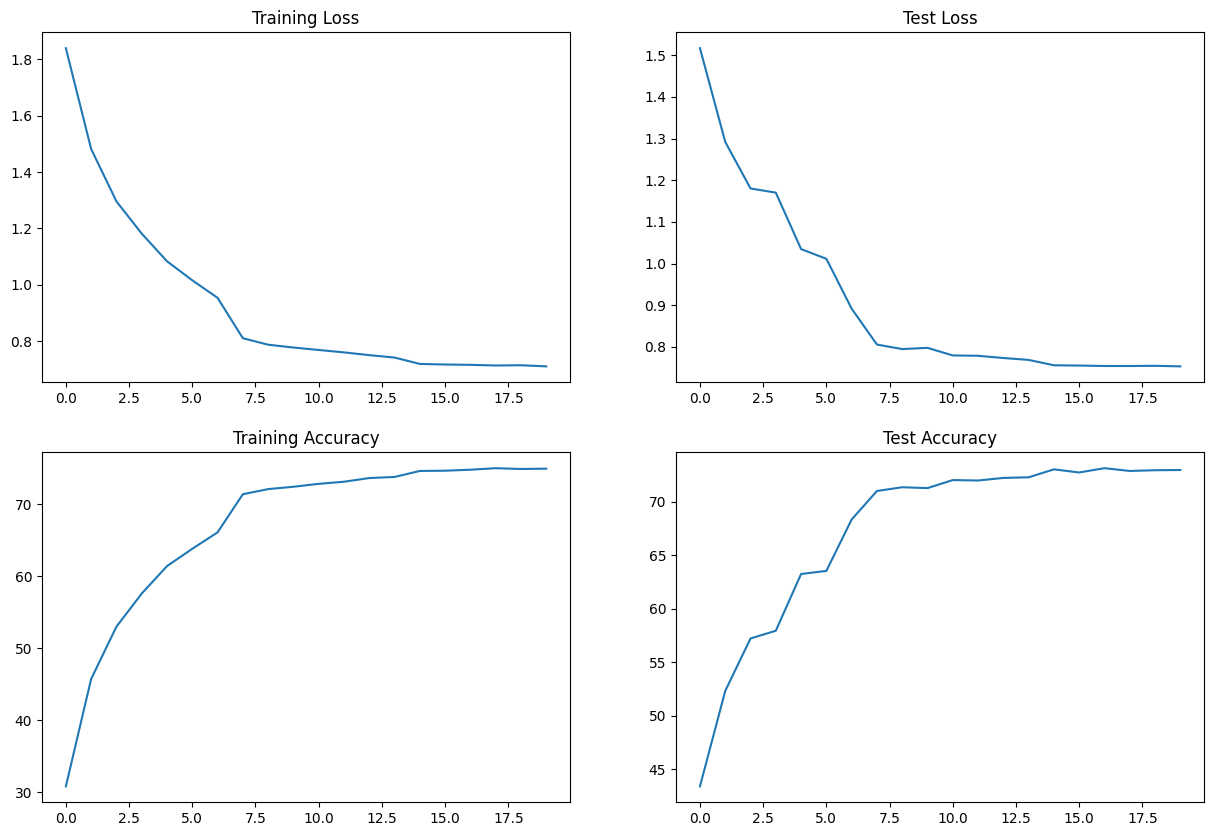

In [17]:
from ERA_V2.S8.Utilities.visualize import plot_model_training_curves

plot_model_training_curves(train_accs=train_accs, test_accs=test_accs, train_losses=train_losses, test_losses=test_losses)

# Model Analysis

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


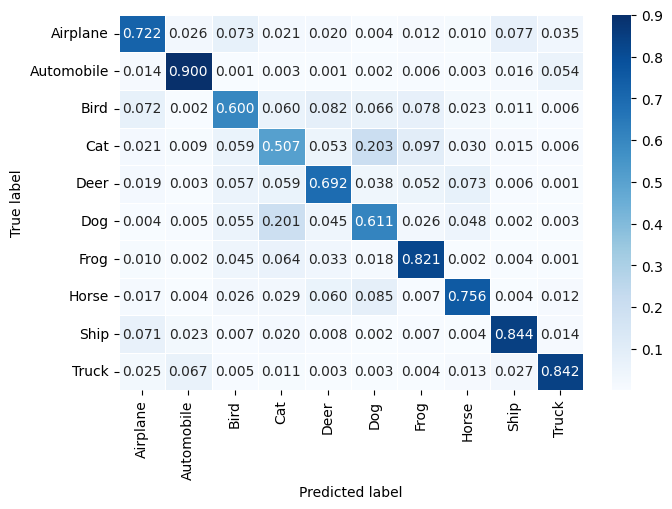

In [18]:
from ERA_V2.S8.Utilities.utils import get_all_and_incorrect_preds
from ERA_V2.S8.Utilities.visualize import plot_confusion_matrix

all_preds, all_labels, incorrect = get_all_and_incorrect_preds(model=model, loader=test_loader, device=device)
plot_confusion_matrix(all_labels, all_preds, classes=CLASSES)

Total Incorrect Predictions 2705


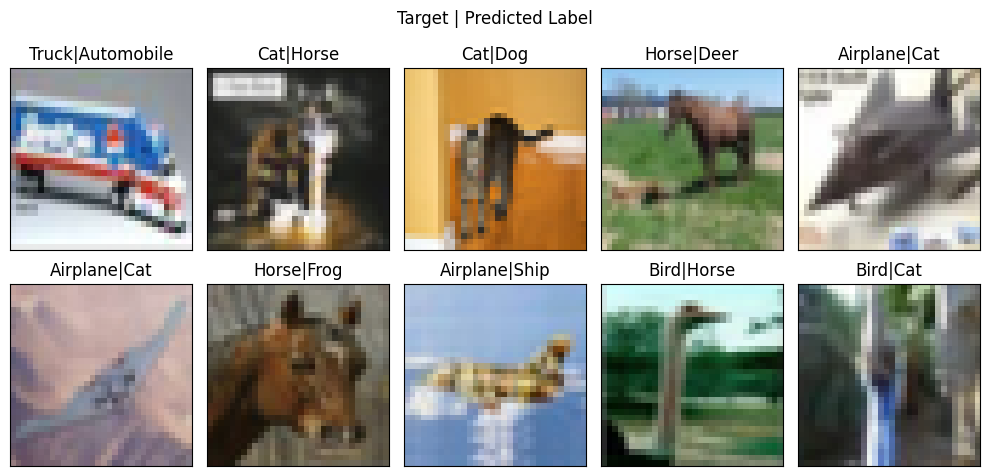

In [19]:
from ERA_V2.S8.Utilities.visualize import plot_incorrect_preds

plot_incorrect_preds(incorrect, classes=CLASSES)